# **Project 1: Stock Price Prediction**

Greetings evaluators!

Here, I will be using the ARIMA model to predict the Closing Price of NVDA stock for trading days 24/10/2022 - 4/11/2022. 

For data to be stationary,
- rolling mean and std should be constant => no trend/seasonality
- In adf test, TestStatistic =< CV or p-value should be very less
 


1. Reading & Processing Data
2. Plotting & Analyzing & Transforming Data
  *   Define test_stationarity function to perform rolling stats/ADF test
  *   Plot indexedDataset, rolling stats, perform ADF test
  *   Construct indexedDataset_logScale, analyze it as prev.
  *   Construct logMinusMovingAverage, analyze as prev.
  *   Construct LogScaleMinusExponentialDecayAverage, analyze.

3.  ACF and PACF Plots, 
4. Construct ARIMA(p,d,q) model and train



In [1]:
#Importing necessary modules

from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=16,8
import os
import math

# 1. Reading & Processing Data

I will be making use of the NVDA.csv dataset containing Closing Prices from Jan.1999 to Oct.2022. For training, I will train using 2 sets of data:
1. One containing ClosePrice from Jan.1999 to Oct.2022
2. Other containing ClosePrice from Jan.2015 to Oct.2022 (To reflect more recent trends in the market after 2015)

For analyzing, I will use Set#1, and for training I will again segregate into data from 2015-22.

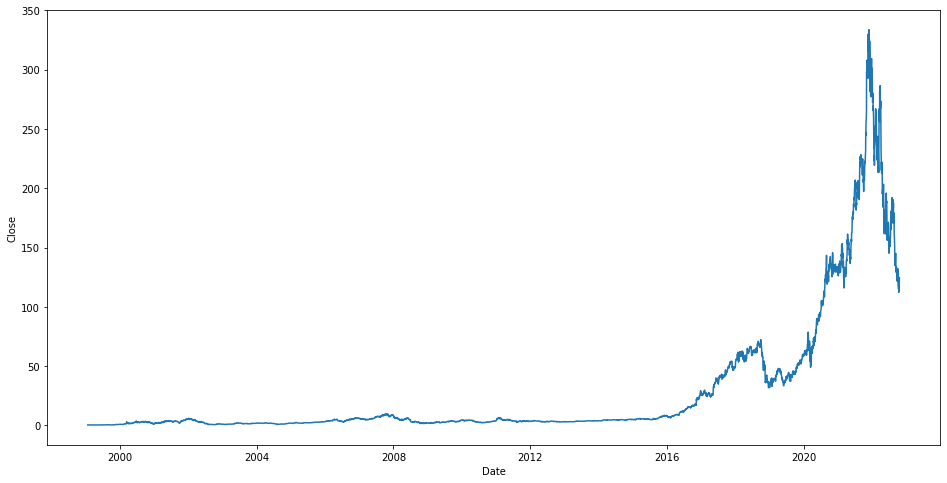

In [3]:
df=pd.read_csv("NVDAFinal.csv")

df["Date"]=pd.to_datetime(df.Date,format="%d/%m/%Y")
df.index=df['Date']
plt.figure(figsize=(16,8))

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

indexedDataset = new_dataset.set_index(['Date'])#Processed dataset with index = date and only Close Price data.
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(indexedDataset)

# 2. Plotting & Analyzing & Transforming Data

* Define test_stationarity function to perform rolling stats/ADF test
* Plot indexedDataset, rolling stats, perform ADF test
* Construct indexedDataset_logScale, analyze it as prev.
* Construct logMinusMovingAverage, analyze as prev.
* Construct LogScaleMinusExponentialDecayAverage, analyze.




In [5]:
##Defining function to check stationarity for timeSeries

from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
  #Determing rolling statistics 
  movingAverage = timeseries.rolling(window=365).mean() 
  movingSTD = timeseries.rolling(window=365).std()
  
  #Plot rolling statistics: 
  orig = plt.plot(timeseries, color='blue', label='Original') 
  mean = plt.plot(movingAverage, color='red', label='Rolling Mean') 
  std = plt.plot(movingSTD, color='black', label = 'Rolling Std') 
  plt.legend(loc='best') 
  plt.title('Rolling Mean & Standard Deviation') 
  plt.show(block=False)
  #Perform Dickey-Fuller test: 
  print('Results of Dickey-Fuller Test:') 
  dftest = adfuller(timeseries['Close'], autolag='AIC') 
  dfoutput = pd. Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used', 'Number of Observations Used']) 
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value 
  print(dfoutput)


# 2.1 IndexedDataset

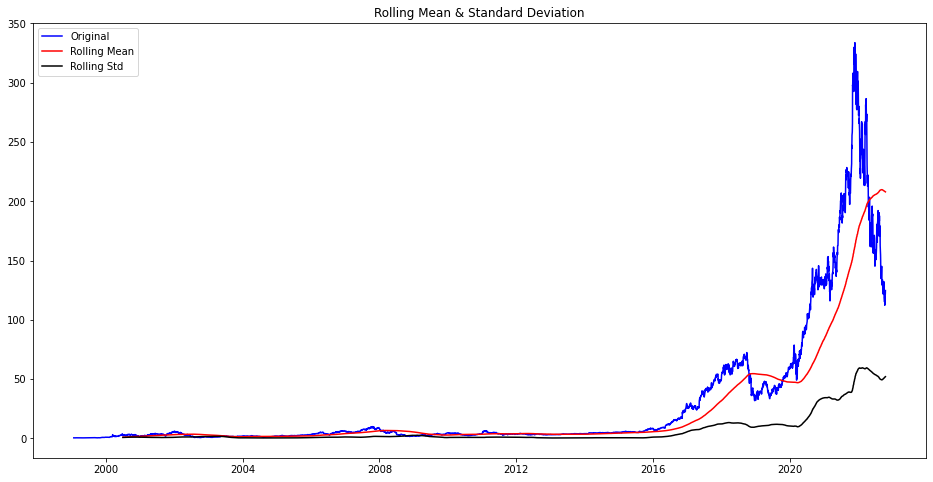

Results of Dickey-Fuller Test:
Test Statistic                   -0.925382
p-value                           0.779499
#Lags Used                       32.000000
Number of Observations Used    5945.000000
Critical Value (1%)              -3.431450
Critical Value (5%)              -2.862026
Critical Value (10%)             -2.567029
dtype: float64


In [6]:
test_stationarity(indexedDataset)

Above, in the stationarity test for indexedDataset, we conclude it is NOT STATIONARY because:
* Rolling mean and Rolling std are not constant, i.e, they have a trend
* p-value is much higher than 0
* Test Statistic > Critical Value(10%) => Can't reject null hypothesis => Data is non-staionary


Next, to estimate the trend and smoothen the curve, we will construct indexedDataset_logScale and analyze it.

# 2.2 indexedDataset_logScale

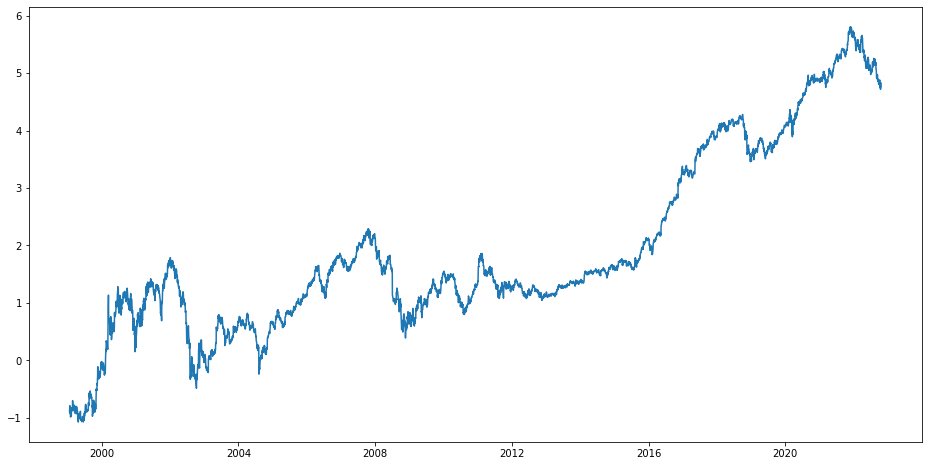

In [7]:
indexedDataset_logScale = new_dataset.set_index(['Date'])
for i in range(0,len(indexedDataset_logScale['Close'])):
  indexedDataset_logScale['Close'][i]=math.log(indexedDataset_logScale['Close'][i])
plt.plot(indexedDataset_logScale)

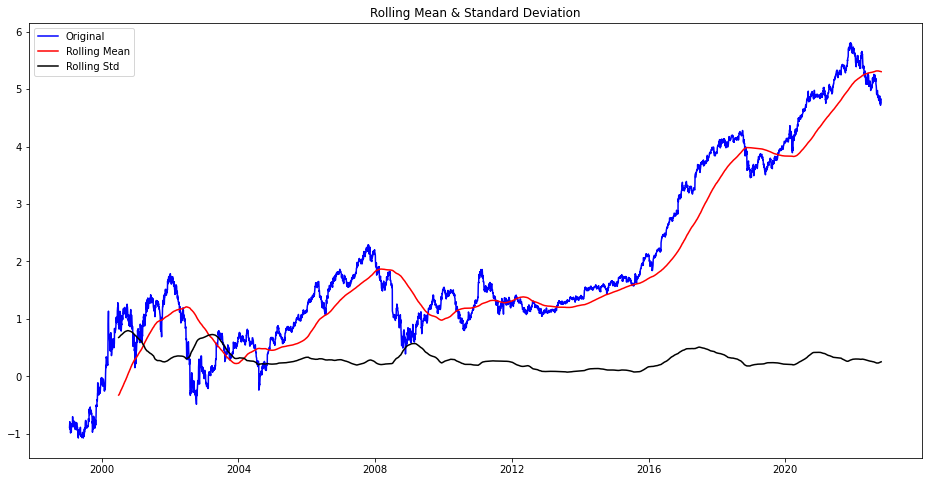

Results of Dickey-Fuller Test:
Test Statistic                   -0.844548
p-value                           0.805685
#Lags Used                       24.000000
Number of Observations Used    5953.000000
Critical Value (1%)              -3.431449
Critical Value (5%)              -2.862026
Critical Value (10%)             -2.567029
dtype: float64


In [8]:
test_stationarity(indexedDataset_logScale)

Above, in the stationarity test for indexedDataset_logScale, we conclude it is NOT STATIONARY because:
* Rolling mean is not constant, i.e, it has a trend (Note that rolling std is const)
* p-value is much higher than 0
* Test Statistic > Critical Value(10%) => Can't reject null hypothesis => Data is non-staionary

Next, we will construct datasetLogScaleMinusMovingAverage

# 2.3 datasetLogScaleMinusMovingAverage

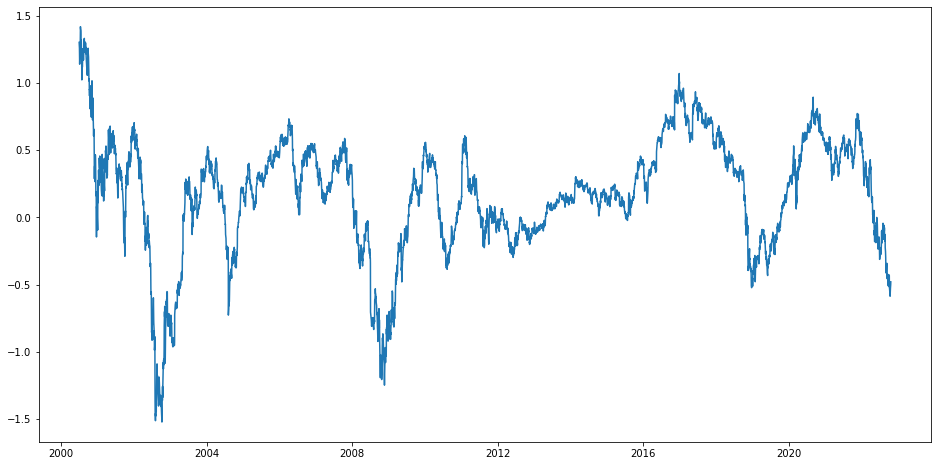

In [9]:
movingAverage = indexedDataset_logScale.rolling(window=365).mean()
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)  #Because it will have 364 NAN values at the start
plt.plot(datasetLogScaleMinusMovingAverage)

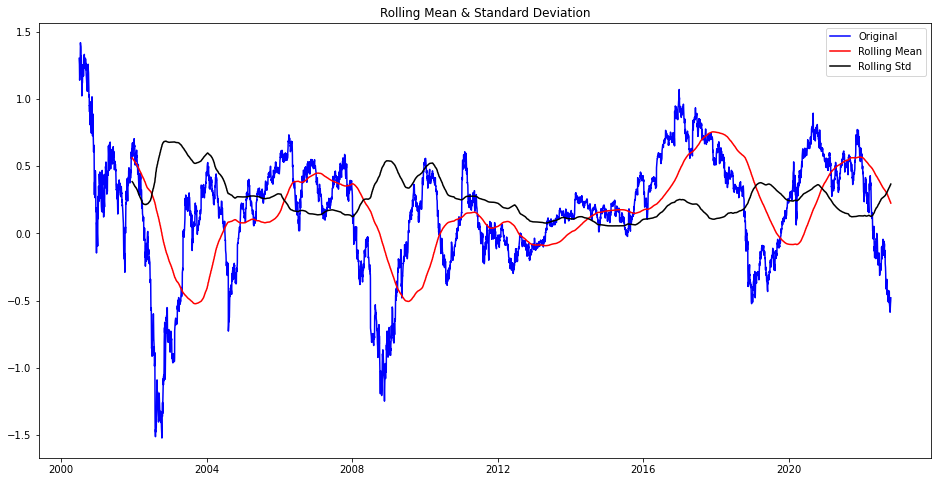

Results of Dickey-Fuller Test:
Test Statistic                   -3.949585
p-value                           0.001699
#Lags Used                       30.000000
Number of Observations Used    5583.000000
Critical Value (1%)              -3.431522
Critical Value (5%)              -2.862058
Critical Value (10%)             -2.567046
dtype: float64


In [10]:
test_stationarity(datasetLogScaleMinusMovingAverage)

Above, in the stationarity test for datasetLogScaleMinusMovingAverage, we conclude it STATIONARY because:
* Rolling mean and rolling std are almost constant, i.e, no overall trend.
* p-value is very close to 0
* Test Statistic < Critical Value(1%) => We Can reject null hypothesis => Data is STATIONARY!

Next, we will construct datasetLogScaleMinusExponentialDecayAverage

# 2.4 datasetLogScaleMinusExponentialDecayAverage

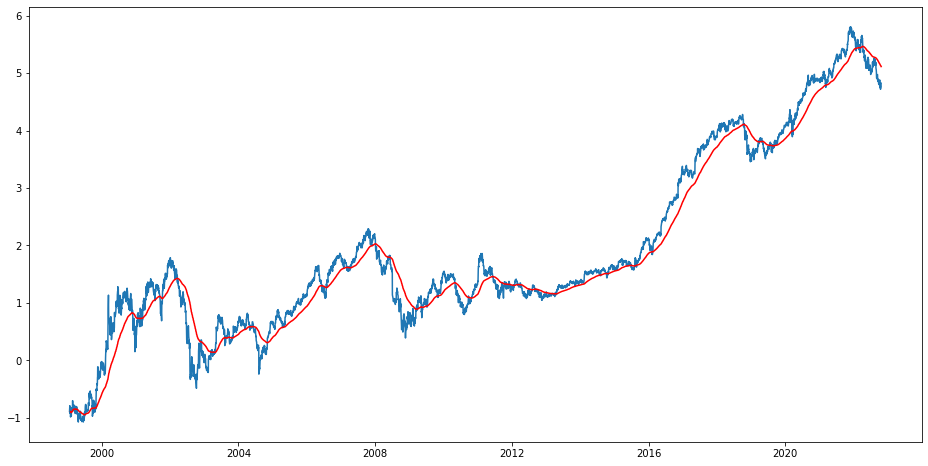

In [11]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=60, min_periods=8, adjust=True).mean() 
plt.plot(indexedDataset_logScale) 
plt.plot(exponentialDecayWeightedAverage, color='red')#Plot for comparison. we observe it smoothens out quite well

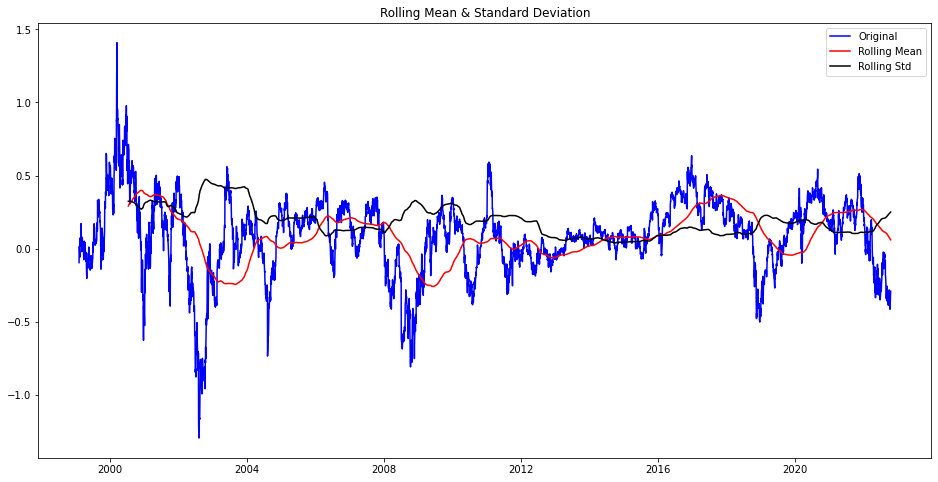

Results of Dickey-Fuller Test:
Test Statistic                   -5.047069
p-value                           0.000018
#Lags Used                       24.000000
Number of Observations Used    5946.000000
Critical Value (1%)              -3.431450
Critical Value (5%)              -2.862026
Critical Value (10%)             -2.567029
dtype: float64


In [12]:
datasetLogScaleMinusExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
datasetLogScaleMinusExponentialDecayAverage.dropna(inplace=True)
test_stationarity(datasetLogScaleMinusExponentialDecayAverage)

Above, in the stationarity test for datasetLogScaleMinusExponentialDecayAverage, we conclude it  STATIONARY because:

* Rolling mean and rolling std are almost constant, i.e, no overall trend.
* p-value is very close to 0
* Test Statistic < Critical Value(1%) => We Can reject null hypothesis => Data is STATIONARY!

# Construct datasetLogDiffShifting to use in TS Forecasting

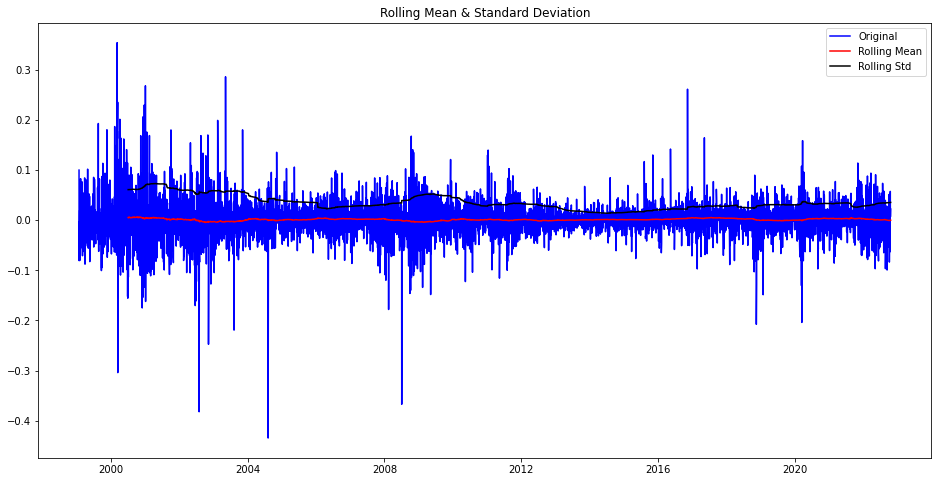

Results of Dickey-Fuller Test:
Test Statistic                -1.513147e+01
p-value                        7.221522e-28
#Lags Used                     2.300000e+01
Number of Observations Used    5.953000e+03
Critical Value (1%)           -3.431449e+00
Critical Value (5%)           -2.862026e+00
Critical Value (10%)          -2.567029e+00
dtype: float64


In [13]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift(1)#shifting values of time series to use in forecsting
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

Analyzing indexedDataset_logScale and plotting trend, seasonality, residual

In [14]:
indexedDataset_logScale

,Close
Date,
1999-01-22,-0.891218
1999-01-25,-0.791587
1999-01-26,-0.872348
1999-01-27,-0.875468
1999-01-28,-0.878598
...,...
2022-10-17,4.778115
2022-10-18,4.784738
2022-10-19,4.791733


In [15]:
indexedDataset_logScale = indexedDataset_logScale.resample('D').first()#Resample to convert to freq = Day

In [16]:
#Compensate for NaN values in resampled indexedDataset_logScale

for i in range(0,len(indexedDataset_logScale)):
  if np.isnan(indexedDataset_logScale['Close'][i]):
    j=i-1
    while(np.isnan(indexedDataset_logScale['Close'][j])):
      j=j-1
    indexedDataset_logScale['Close'][i]=indexedDataset_logScale['Close'][j]

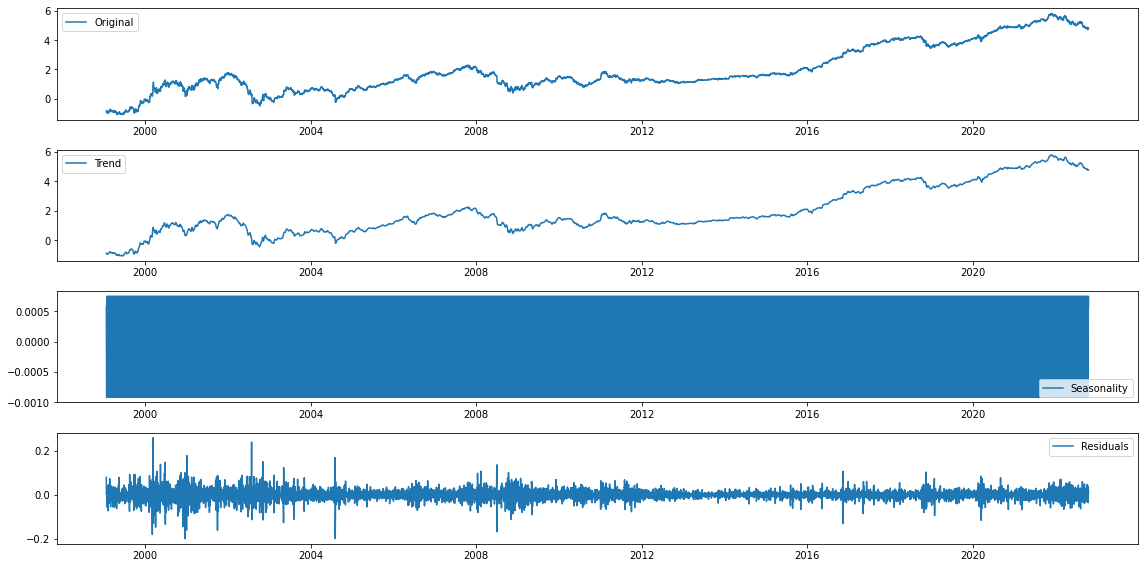

In [17]:
#Decompose and plot graphs for trend, seasonality, irregularity in dataset
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend (loc='best') 
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend (loc='best') 
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend (loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals') 
plt.legend (loc='best') 
plt.tight_layout()

From the above, we conclude that:
* indexedDataset_logScale has a somewhat upward trend, specially after 2004
* It is extremely seasonal in nature
* Data has considerable residual

# 3. Plotting ACF/PACF Plots and determining value of p and q

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


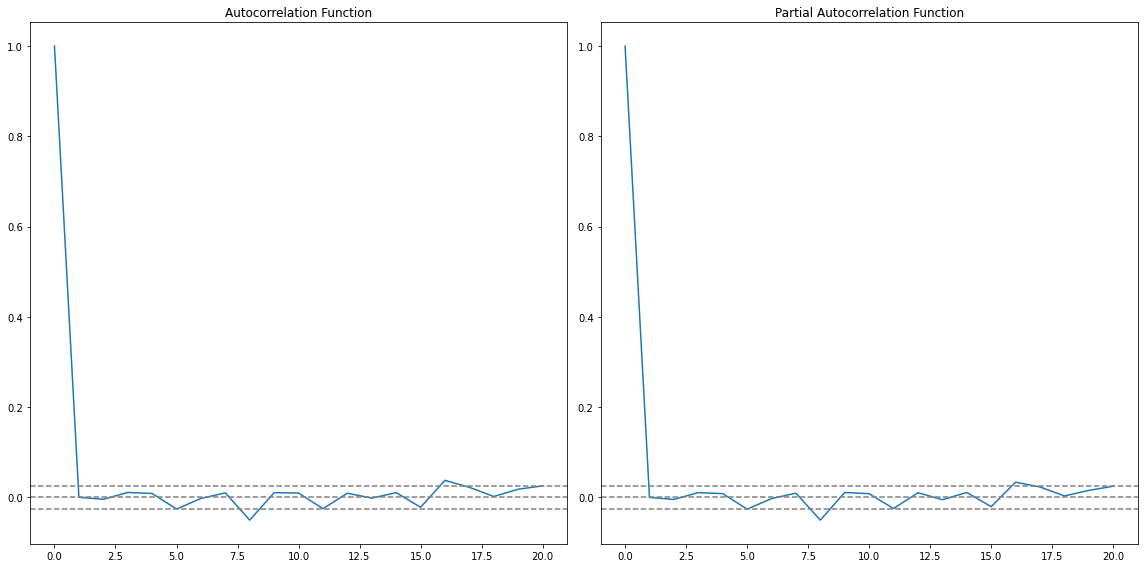

In [18]:
#ACF and PACF plots: 
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20) 
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')#ordinary least square method

#Plot ACF: --> Q value
plt.subplot(121) 
plt.plot(lag_acf) 
plt.axhline(y=0, linestyle='--', color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--',color='gray') 
plt.axhline (y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--',color='gray') 
plt.title('Autocorrelation Function')
#Plot PACF: --> P value 
plt. subplot(122) 
plt.plot(lag_pacf) 
plt.axhline(y=0, linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--',color='gray') 
plt.axhline (y=1.96/np. sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray') 
plt.title('Partial Autocorrelation Function') 
plt. tight_layout()

Let's plot ACF, PACF graphs for normal dataset and the differencing on normal dataset too.

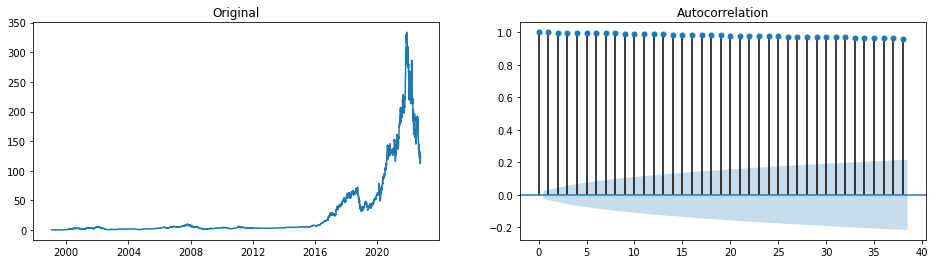

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
plot_acf(df.Close, ax=ax2);

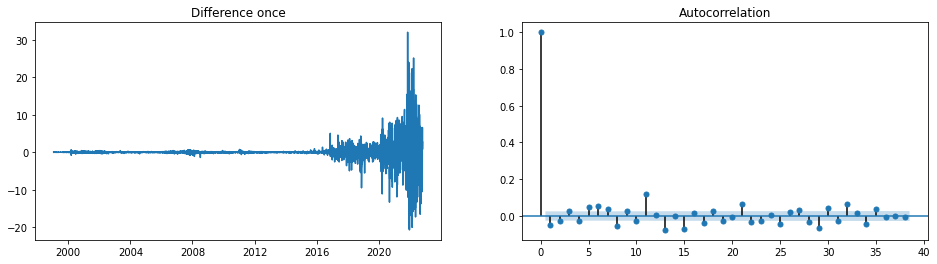

In [20]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

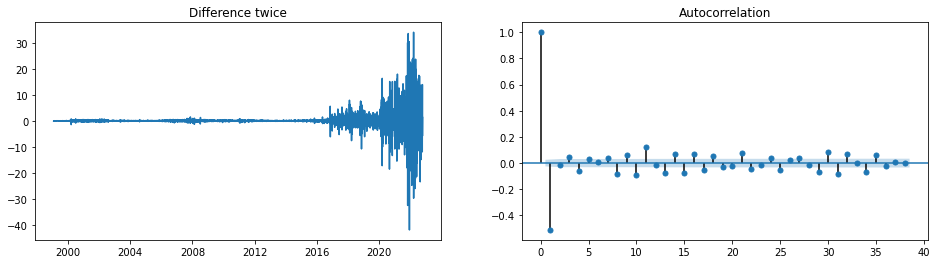

In [21]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);
#

In 2nd differencing, the lag goes into far negative compared to first order of differencing => might be overdiff.

Also, previously we figured out d value = 1. (Based on transformations and processing in 2.4)

so we choose d=1

In [22]:
#from pmdarima.arima.utils import ndiffs
#ndiffs(df.Close,test="adf") ----> to get order of differencing definitely. 
#This module pmdarima clashes with statsmodels, so I have commented it out, basically, this also gives d=1

# PACF to determine p value

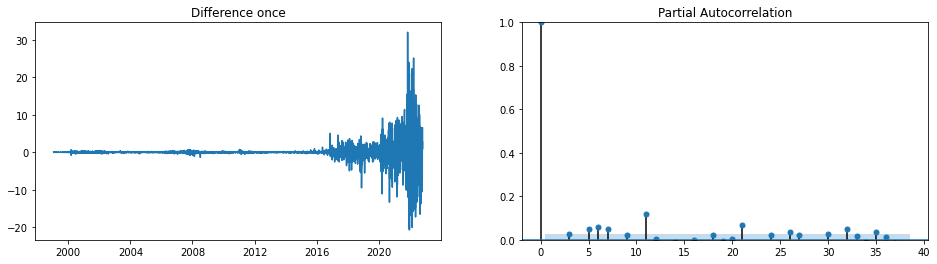

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

Lag #11 stands out, significantly above the significant line. 
P=11

# ACF to determine q value

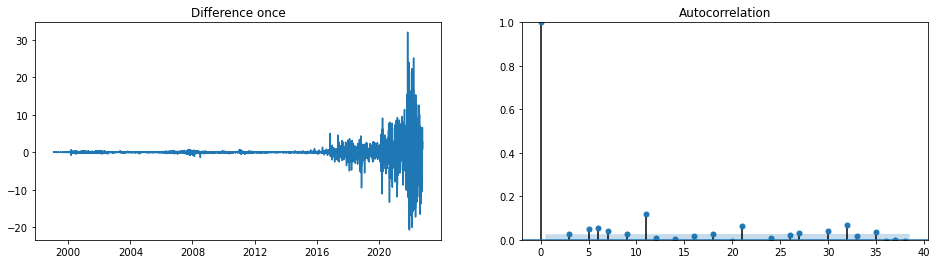

In [24]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Here forecast error#5 may be suitable for MA parameter. thus, Q=5

# Training the model using ARIMA(11,1,5)

I tried using many versions of p,d,q:
(2,1,2)
(1,1,1)
(11,1,6)
(6,1,6)

I found (11,1,5) to be the optimal choices for p,d,q thus used them below

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model
model = ARIMA(df.Close, order=(11, 1, 5))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

In [26]:
print(result.summary())

##if any of the coeeff close to 0, can remove that term, 
#if P value very high then can also reject, P value should be close to 0 so that they are imp to model

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5978
Model:                ARIMA(11, 1, 5)   Log Likelihood              -12829.344
Date:                Sun, 23 Oct 2022   AIC                          25692.689
Time:                        15:25:59   BIC                          25806.515
Sample:                             0   HQIC                         25732.225
                               - 5978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6494      0.025    -25.482      0.000      -0.699      -0.599
ar.L2          0.0830      0.010      8.579      0.000       0.064       0.102
ar.L3          0.1123      0.011     10.571      0.0

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-21.35851037, -15.93604637, -10.51358236,  -5.09111836,
          0.33134564,   5.75380965,  11.17627365,  16.59873765,
         22.02120165,  27.44366566,  32.86612966]),
 <a list of 5978 Lists of Patches objects>)

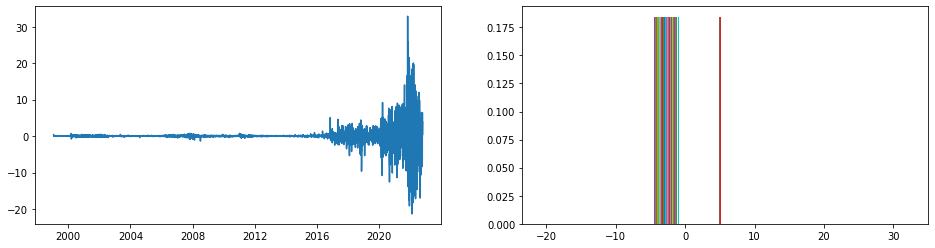

In [27]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


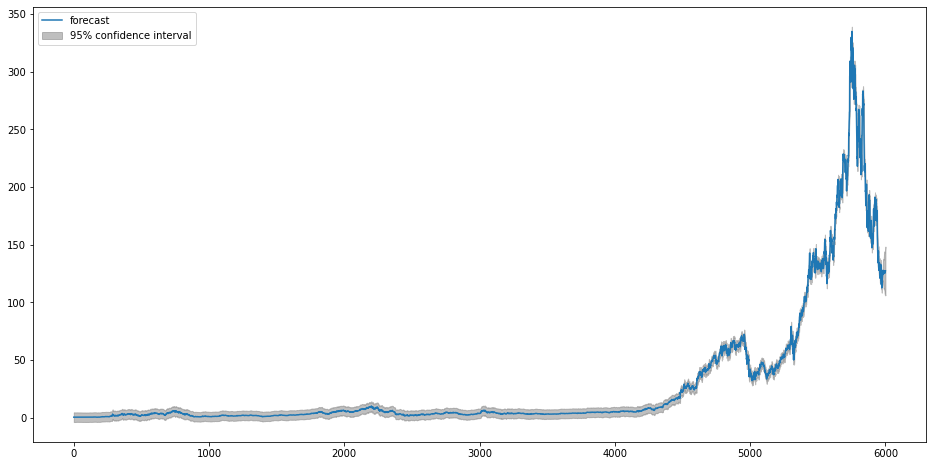

In [28]:
from statsmodels.graphics.tsaplots import plot_predict
# Actual vs Fitted
plot_predict(result,
    start=1,
    end=6000,
    dynamic=False,
);

# 

PREDICTIONS FOR NEXT 10 DAYS from 24/10/2022 to 4/11/2022

In [29]:
result.forecast(10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5978    122.576721
5979    122.891427
5980    125.035533
5981    124.888133
5982    127.788731
5983    126.850323
5984    126.794873
5985    126.077725
5986    124.612183
5987    125.319933
Name: predicted_mean, dtype: float64